In [166]:
# Add a retrosynthesis style arrow when drawing reactions in RDKit

# V.F. Scalfani
# Novemeber 22, 2023
# BSD license

# This is a rough SVG text edit approach; it modifies the SVG output from RDKit.
# There is likely a better way to do this by drawing molecules and arrows
# in arbitary positions natively on the canvas, see:
# https://github.com/rdkit/UGM_2023/blob/main/Notebooks/Landrum_WhatsNew.ipynb

# Attribution: ChatGPT4 to figure out syntax of SVG and how to modify arrow.

In [167]:
# imports
from rdkit import Chem
from rdkit.Chem import rdChemReactions
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG
import re

In [168]:
from rdkit import rdBase
print('RDKit version:',rdBase.rdkitVersion)

RDKit version: 2023.09.2


In [169]:
# Basic function to draw reactions
def draw_reaction(rxn):
    drawer = rdMolDraw2D.MolDraw2DSVG(700,250)
    drawer.drawOptions().fixedScale = 0.1
    drawer.DrawReaction(rxn)
    drawer.FinishDrawing()
    rxn_svg = drawer.GetDrawingText()
    return rxn_svg

In [170]:
# Some reverse rxn examples:
# 0 Diels-Alder
# 1 adapted from USPTO dataset
# 2 adapted from: https://github.com/rdkit/UGM_2021/blob/main/Notebooks/Landrum_WhatsNew.ipynb

rsmis = ['[CH2:5]1[CH2:6][CH2:1][CH:2]=[CH:3][CH2:4]1>>[CH2:1]=[CH:2][CH:3]=[CH2:4].[CH2:5]=[CH2:6]',
'[Cl:11][CH2:12][CH2:13][N:4]1[CH2:5][CH:6]([CH3:10])[S:7](=[O:9])(=[O:8])[CH:2]([CH3:1])[CH2:3]1>>\
[CH3:1][CH:2]1[S:7](=[O:9])(=[O:8])[CH:6]([CH3:10])[CH2:5][NH:4][CH2:3]1.[Cl:11][CH2:12][CH:13]=O',
'[cH:1]:1:[cH:2]:[cH:3]:[cH:4]:[cH:5](-[C:6]#[N:7]):[c:8]:1-[cH:15]:1[cH:10]:[cH:11]:[cH:12]\
(-[Cl:16]):[cH:13]:[cH:14]:1>>[cH:1]:1:[cH:2]:[cH:3]:[cH:4]:[cH:5](-[C:6]#[N:7]):[c:8]:1-[Cl].[cH:10]\
:1:[cH:11]:[cH:12](-[Cl:16]):[cH:13]:[cH:14]:[cH:15]:1-B(-O)-O']

In [171]:
# create rxns
rxns = []
for rsmi in rsmis:
    rxns.append(rdChemReactions.ReactionFromSmarts(rsmi, useSmiles=True))

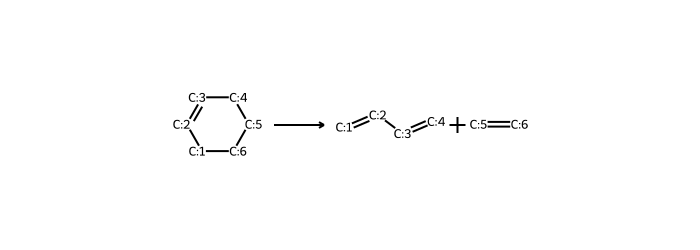

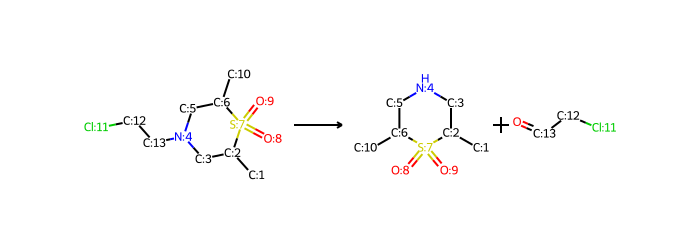

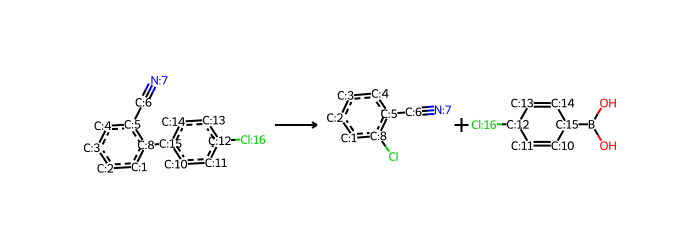

In [172]:
# display
for rxn in rxns:
    display(SVG(draw_reaction(rxn)))

In [173]:
# draw as SVGs and save to file
for idx,rxn in enumerate(rxns):
    mysvg = draw_reaction(rxn)
    with open('rxn' + str(idx) + '.svg', 'w') as out:
         out.write(mysvg)

In [174]:
# As far as I can tell, the rxn arrow drawing is always at the end of the SVG file
# generated from RDKit

# example
#1 - <path d='M 228.0,125.0 L 266.0,125.0' style='fill:none;fill-rule:evenodd;stroke:#000000...
#2 - <path d='M 266.0,125.0 L 261.0,127.9' style='fill:none;fill-rule:evenodd;stroke:#000000...
#3 - <path d='M 266.0,125.0 L 261.0,122.1' style='fill:none;fill-rule:evenodd;stroke:#000000...

# Interpretation:

# Line 1 is the line for the arrow

# Move to   X1    Y1     draw line    X2     Y2
#      'M 228.0,125.0            L 266.0,125.0' 

# Lines 2 and 3 draw the arrow head

In [175]:
# Read in the SVG as a list of lists
svg_lists = []
for idx in range(0,3):
    with open('rxn' + str(idx) + '.svg', 'r') as infile:
         svg_lists.append(infile.readlines())

In [176]:
def add_retro_arrow(svg_list):

    ### 1. Add a second horizontal line
    # loop through list in reverse and
    # locate the 3rd occurence of <path d='M...
    # this is the arrow line

    svg_retro = []
    for idx, svg_line in enumerate(reversed(svg_list)):
        if svg_line.startswith("<path d='M"):
            # locate 3rd occurence
            if idx == 3:
                # add a copy of this line before (in reverse)
                svg_retro = svg_list.copy()
                svg_retro.insert(-3, svg_line)

    # shift the newly added line in Y vertical position
    # find float numbers with regex, first 4 numbers is all we need.

    l1 = re.findall(r'\d+\.\d+', svg_retro[-4])
    l1_nums = [float(num) for num in l1]
    l1_X1, l1_Y1, l1_X2, l1_Y2 = l1_nums[:4]

    # format new string, shift vertical by 5 units
    
    end_string = "' style='fill:none;fill-rule:evenodd;stroke:#000000;stroke-width:2.0px;stroke-linecap:" + \
    "butt;stroke-linejoin:miter;stroke-opacity:1' />\n"

    svg_retro[-4] = "<path d='M " + str(l1_X1) + "," + str(l1_Y1 + 5) + " L " + \
        str(l1_X2) + "," + str(l1_Y2 + 5) + end_string

    ### 2. Increase size of arrowheads and shift arrowhead vertically between lines
 
    # get positions for arrowheads, which are lines idx -3,-2
    a1 = re.findall(r'\d+\.\d+', svg_retro[-3])
    a2 = re.findall(r'\d+\.\d+', svg_retro[-2])

    a1_nums= [float(num) for num in a1]
    a2_nums= [float(num) for num in a2]

    a1_X1, a1_Y1, a1_X2, a1_Y2 = a1_nums[:4]
    a2_X1, a2_Y1, a2_X2, a2_Y2 = a2_nums[:4]

    # Compute new longer draw position for arrow head (3x original length):

    a1_X2_new = round((a1_X1 + 3 * (a1_X2 - a1_X1)),1)
    a1_Y2_new = round((a1_Y1 + 3 * (a1_Y2 - a1_Y1)),1)
    a2_X2_new = round((a2_X1 + 3 * (a2_X2 - a2_X1)),1)
    a2_Y2_new = round((a2_Y1 + 3 * (a2_Y2 - a2_Y1)),1)

    # format new strings with longer arrowheads
    # also included is to shift the Y positions down between the lines (half the distance from step 1)
    
    svg_retro[-3] = "<path d='M " + str(a1_X1) + "," + str(a1_Y1 + 2.5) + " L " + \
        str(a1_X2_new) + "," + str(a1_Y2_new + 2.5) + end_string

    svg_retro[-2] = "<path d='M " + str(a2_X1) + "," + str(a2_Y1 + 2.5) + " L " + \
        str(a2_X2_new) + "," + str(a2_Y2_new + 2.5) + end_string

    ### 3. Finally, shorten arrow lines a little, so they don't overlap with arrowhead
    # this just adjusts the X2 value

    svg_retro[-4] = "<path d='M " + str(l1_X1) + "," + str(l1_Y1 + 5) + " L " + \
          str(l1_X2 - 5) + "," + str(l1_Y2 + 5) + end_string

    l2 = re.findall(r'\d+\.\d+', svg_retro[-5])
    l2_nums = [float(num) for num in l2]
    l2_X1, l2_Y1, l2_X2, l2_Y2 = l2_nums[:4]

    svg_retro[-5] = "<path d='M " + str(l2_X1) + "," + str(l2_Y1) + " L " + str(l2_X2 - 5) + \
          "," + str(l2_Y2) + end_string
   
    return svg_retro

In [177]:
# add the retrosynthesis arrow
modified_svgs = []
for svg_list in svg_lists:
    modified_svgs.append(add_retro_arrow(svg_list))

In [178]:
# write modified svgs
for idx, modified_svg in enumerate(modified_svgs):
    with open('rxn' + str(idx) +'_retro.svg', 'w') as outfile:
        for line in modified_svg:
            outfile.write(line)

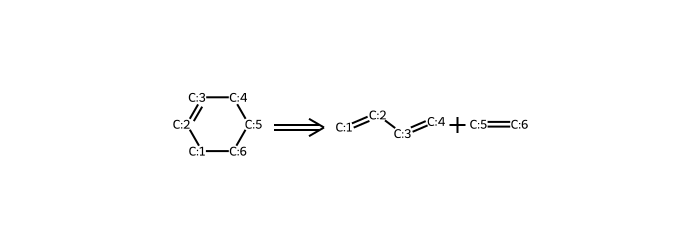

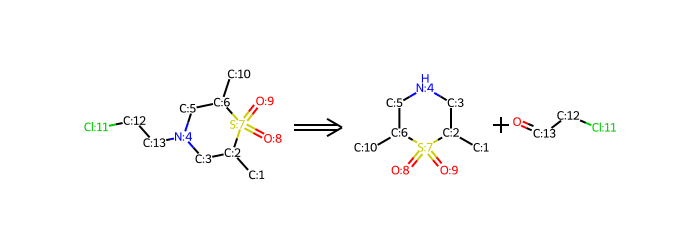

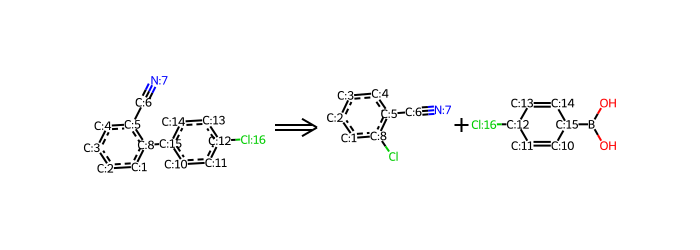

In [179]:
# view modified svgs
for idx in range(0,3):
    with open('rxn' + str(idx) +'_retro.svg', 'r') as infile:
        svg_content = infile.read()
        display(SVG(svg_content))